## Rotational Transformer (RT) Model for Natural Language Processing (NLP)
This notebook is based on __Andrej Karpathy__'s [YouTube lecture video](https://www.youtube.com/watch?v=kCc8FmEb1nY&t=120s) and the associated [Notebook](https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing#scrollTo=wJpXpmjEYC_T). Big thanks to Andrej Karpathy!

### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F


import tiktoken                                             # !pip install tiktoken (tiktoken is a fast BPE tokeniser for use with OpenAI's models.)
from transformers import get_cosine_schedule_with_warmup

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Load the [tiny shakespeare](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt) dataset for training

This code block reads the tiny Shakespeare dataset stored locally, builds a character-level vocabulary, and encodes the text into a tensor of integer token IDs. It then splits the encoded data into 90% training and 10% validation sets.

In [2]:
%%time

with open('tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(f'number of characters: {len(text)}\n')


#=======================================================================================================
# here are all the unique characters that occur in this text

chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f'vocab_size = {vocab_size}')

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]               # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l])      # decoder: take a list of integers, output a string

data = torch.tensor(encode(text), dtype=torch.long)   # encode the entire text dataset and store it into a torch.Tensor

#=======================================================================================================

# LLModel = 'gpt2'
# enc = tiktoken.encoding_for_model(LLModel) # can use other model at the place of 'gpt2' from the OpenAI Cookbook.
# vocab_size = enc.n_vocab
# print(f'number of tockens in the LLModel {LLModel} = {vocab_size}')
# data = torch.tensor(enc.encode(text), dtype=torch.long)

#=======================================================================================================

data_size = len(data)
print(f'dataset size = {data_size}\n')


# Let's now split up the data into train and validation sets
n = int(0.9 * data_size) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]


number of characters: 1115394

vocab_size = 65
dataset size = 1115394

CPU times: user 47.8 ms, sys: 2.68 ms, total: 50.5 ms
Wall time: 50.1 ms


### Rotational Transformer (RT) Model

This code implements a custom RT Model that is a combination of the famous [Transformer Architecture](https://arxiv.org/abs/1706.03762) and single-qubit rotations only.


$\bullet$ __get_batch__: Picks random slices of the dataset to form input (x) and target (y) sequences of length `block_size`, and moves them to the right device for training. <br>
$\bullet$ __rotational_embedding__: Learns a set of $n$ angles for each token, where $n$ is the number of qubits. Converts each angle into a single‑qubit state $|\phi\rangle:=[\cos\phi, \sin\phi]$ by applying rotation around $y$-axis to the single-qubit state $|0\rangle:=[1, 0]$.
Takes the tensor (Kronecker) product of those state vectors to build a $2^n$‑dimensional state vector. Squares each amplitude to get a probability vector of length $2^n$, 
corresponding to the measurement in the computational basis. <br>
$\bullet$ __parallel_rotations__:
Takes input probability vectors, standardizes and normalizes them into unit‑length “state” vectors. Applies many multi‑qubit rotation operators $\textbf{R}_y(\Phi):=\otimes_{i=1}^n R_y(\phi_i)$ in parallel. Measures each output to get new probability vectors, where we use the identity $\langle 0|\textbf{R}_y(\Phi)|x\rangle=\langle \Phi|x\rangle$, $|\Phi\rangle:=\otimes_{i=1}^n |\phi_i\rangle$. <br>
$\bullet$ __rotational_self_attention_head__: Uses three `parallel_rotations` to produce queries, keys, and values from token embeddings.
Computes raw attention scores by matrix‑multiplying q @ kᵀ/√d. Applies a lower‑triangular mask so each token only attends to itself and earlier ones.
Multiplies those weights by v to get one head’s output. <br>
$\bullet$ __rotational_multi_head_attention__: Runs multiple attention heads in parallel and concatenates their outputs. Feeds the result through one more parallel_rotations layer for mixing. <br>
$\bullet$ __rotational_feedforward__:
A two‑stage rotation network: expands each token’s features to $4\times$size, then contracts back, adding depth and nonlinearity. <br>
$\bullet$ __rotational_block__: 
One Transformer block: <br>
Self‑attention + skip connection <br>
Feed‑forward + skip connection <br>
$\bullet$ __RT (Rotational Transformer)__: <br>
Embedding: maps token indices to probability vectors via `rotational_embedding`. <br>
Blocks: stacks several `rotational_blocks`. <br>
Last layer: maps final features back to vocabulary‑sized probabilities via `parallel_rotations`. <br>
Forward: returns normalized probabilities (and NLL loss if you pass in targets). <br>
Generate: autoregressively samples new tokens by feeding the last output back into the model. <br>


Altogether, this defines a "Rotational Transformer" that replaces classical linear layers with learned qubit-rotation networks. The model uses only single-qubit rotations, which are easily implementable on quantum hardware. This notebook provides a classical simulation of these quantum rotations using PyTorch.


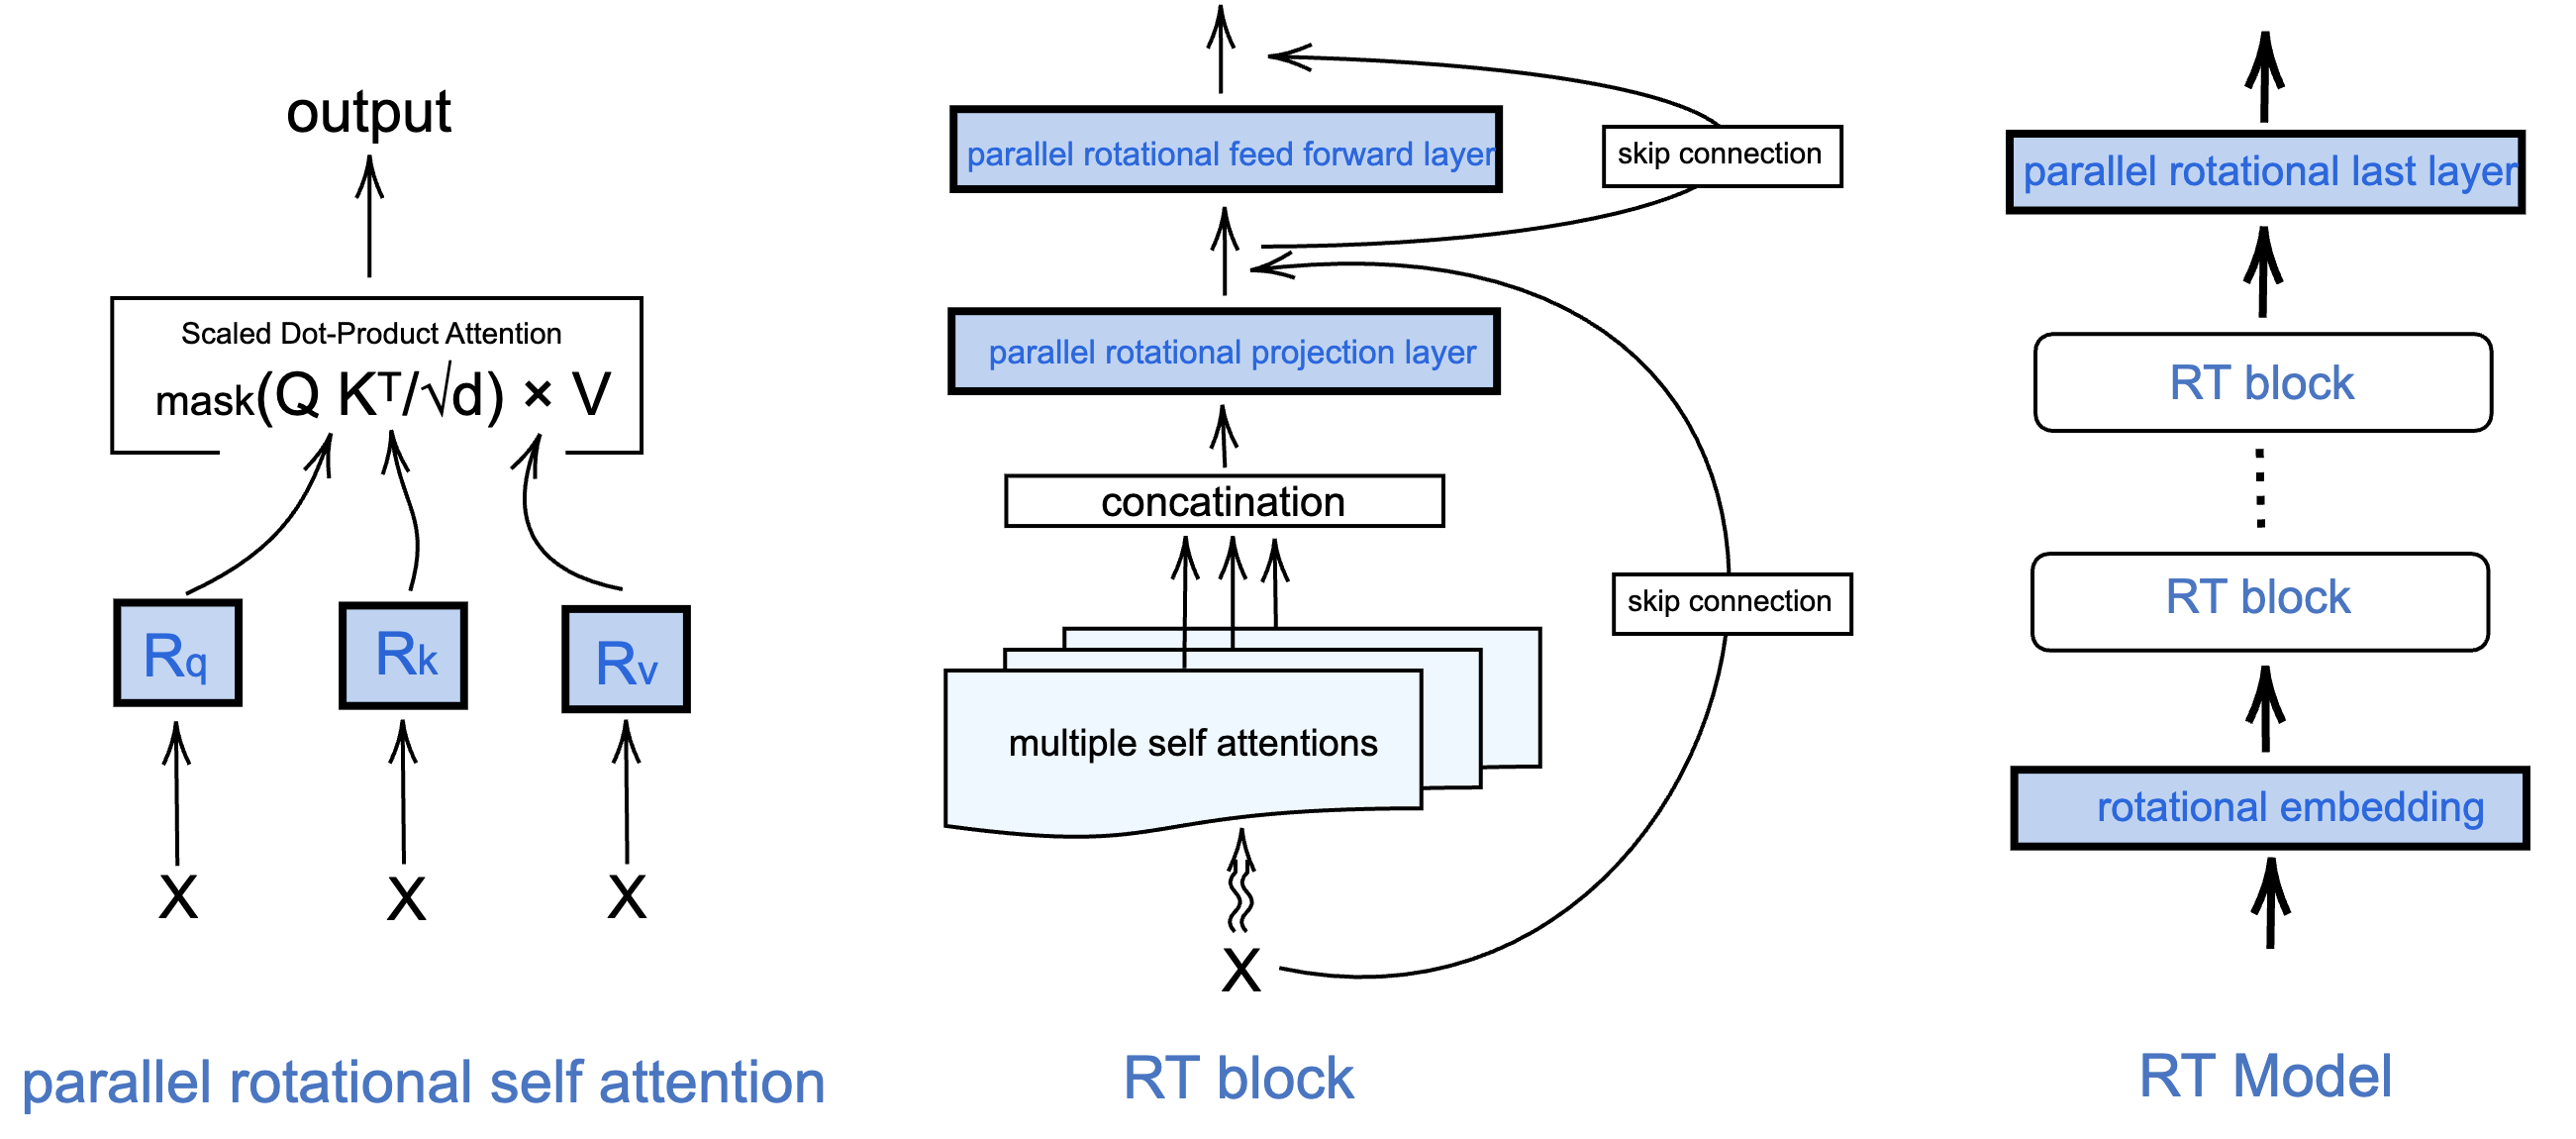

In [3]:
#torch.manual_seed(1)                                          # setting a specific seed for reproducibility of results


def get_batch(dataset, batch_size, block_size):
    # generate a small batch of data of inputs x and targets y
    ix = torch.randint(len(dataset) - block_size, (batch_size,))
    x = torch.stack([dataset[i:i+block_size] for i in ix])
    y = torch.stack([dataset[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y



class rotational_embedding(nn.Module):
    '''RE maps token index i to its (learnable) probability-vector '''
    def __init__(self, num_embd, embd_dim):       # num_embd = vocab_size
        super().__init__()

        self.embd_dim = embd_dim                  # MUST OBEY: embedding dimention = 2^n = n-qubit Hilbert space dimension
        n = int(np.log2(embd_dim))                # number of qubits

        angles = torch.randn((num_embd, n), dtype=torch.float)    
        nn.init.xavier_uniform_(angles)
        self.angles = nn.Parameter(angles)

    
    def kronecker_prod(self, qstate_vecs):            # (B, T, n, 2)
        B, T, n, _ = qstate_vecs.shape
        nqstate_vecs = qstate_vecs[:, :, 0, :]        # Start with the first qubit state-vector for each token
        for i in range(1, n):
            # Outer product between the current multi-qubit state-vector and the next qubit state-vector 
            nqstate_vecs = torch.einsum('...i,...j->...ij', nqstate_vecs, qstate_vecs[:, :, i, :]).reshape(B, T, -1)
        return nqstate_vecs                           # (B, T, dim) where dim = 2^n
        

    def forward(self, x):                                     # Input tensor x of integers of shape (B, T) where B is batch size and T is block size.
        phi = self.angles[x]                                  # Select angle vector phi_i corresponding to each token index i in 'x'. x.shape = (B, T, n)
        cos_phi = torch.cos(phi)
        sin_phi = torch.sin(phi)
                                                              # collection of single qubit normalized qstate_vecs: [cos(phi), sin(phi)]
        qubit_qstate_vecs = torch.stack([cos_phi, sin_phi], dim=-1)                        # (B, T, n, 2)
        multi_qubit_qstate_vecs = self.kronecker_prod(qubit_qstate_vecs)                   # normalized multi_qubit qstate_vecs |Phi> = R(Phi)|0> of shape (B, T, dim)
                                                                                           # measurement in the computational basis {|l>} 
        probs = multi_qubit_qstate_vecs * multi_qubit_qstate_vecs                          # probability-vector made of |<l|Phi>|^2 where l = 0,1,..., dim -1 
        return probs                                                                                                                




class parallel_rotations(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
 
        self.dim_in = dim_in                    # number of rotations in parallel = dim_out (each rotation is in dim_in dimensional Hilbert space)
        n = int(np.log2(dim_in))                # number of qubits 

        angles = torch.randn((dim_out, n), dtype=torch.float)     
        nn.init.xavier_uniform_(angles)
        self.angles = nn.Parameter(angles)
    
    
    def kronecker_prod(self, qstate_vecs):                 # (dim_out, n, 2)
        d, n, _ = qstate_vecs.shape
        nqstate_vecs = qstate_vecs[:, 0, :]                # Start with the first qubit state-vector for each token
        for i in range(1, n):
            # Outer product between the current multi-qubit state-vector and the next qubit state-vector 
            nqstate_vecs = torch.einsum('...i,...j->...ij', nqstate_vecs, qstate_vecs[:, i, :]).reshape(d, -1)  
        return nqstate_vecs                                # (dim_out, dim_in) where dim_in = 2^n

    
    def forward(self, x):                                  # (B, T, dim_in)            here dim_in = embd_dim
        # if input x is made of probabilities, it has only positive numbers 
        # then, after z-score normalization or LayerNorm (zero mean and unit variance), output x has both positive and negative numbers
        x = (x - torch.mean(x, dim=-1, keepdim=True))/torch.std(x, dim=-1, keepdim=True) 
        x = F.normalize(x, p=2, dim=-1)                    # turning x into quantum state-vector |x>
        

        cos_phi = torch.cos(self.angles)
        sin_phi = torch.sin(self.angles)
                                                           # collection of single qubit (unnormalized) qstate_vecs: [cos(phi), sin(phi)]
        qstate_vecs = torch.stack([cos_phi, sin_phi], dim=-1)                        # (dim_out, n, 2)
        nqstate_vecs = self.kronecker_prod(qstate_vecs)                              # (dim_out, dim_in)

        
        # Perform dim_out parallel rotations, and the measurement in the computational basis {|l>}
        # (B, T, dim_in) @ (dim_in, dim_out) --> (B, T, dim_out)

        x = (x @ nqstate_vecs.transpose(-2,-1))           # probability amplitudes = <0|R(Phi_k)|x>    for k = 0,1,..., dim_out -1       
        
        x = x*x                                           # probability p_k = |<0|R(Phi_k)|x>|^2. Note: sum_k p_k is not necessarily 1.    
        return x    


#===========================================================================================================================================
#===========================================================================================================================================


class rotational_self_attention_head(nn.Module):
    def __init__(self, dim_in, dim_out, block_size):
        super().__init__()
        
        self.key = parallel_rotations(dim_in, dim_out)                    # here (dim_in, dim_out) = (embd_dim, head_size)
        self.query = parallel_rotations(dim_in, dim_out)
        self.value = parallel_rotations(dim_in, dim_out)
        
        # Register `tril (lower triangular matrix for masking)` as a buffer so that it is not updated during training
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):                       # x.shape = (B, T, embd_dim)
        
        B,T,C = x.shape
        
        k = self.key(x)                         # k.shape = (B, T, head_size)  passing kets |x> -- through parallel_rotations --> |<0|k>|^2
        q = self.query(x)                       # q.shape = (B, T, head_size)  passing kets |x> -- through another parallel_rotations --> |<0|q>|^2
        v = self.value(x)                       # v.shape = (B, T, head_size)  passing kets |x> -- through yet another parallel_rotations --> |<0|v>|^2
        
        # compute attention scores ('affinities') through the multiplication of matrices (in the classical computer) q and k made of probabilities 
        # weights are not normalized 
        weights = q @ k.transpose(-2,-1) * C**0.5                  # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)                
        weights = weights.masked_fill(self.tril[:T,:T]==0, 0)      # (B, T, T) lower triangular matrix for masking

        
        # perform the weighted aggregation of the values (in the classical computer): (B, T, T) @ (B, T, head_size) -> (B, T, head_size)
        out = weights @ v                                     
        
        return out




class rotational_multi_head_attention(nn.Module):
    ''' multiple heads of rotational self-attention in parallel '''

    def __init__(self, embd_dim, num_heads, block_size):
        super().__init__()
        head_size = embd_dim // num_heads
        
        self.heads = nn.ModuleList([rotational_self_attention_head(embd_dim, head_size, block_size) for _ in range(num_heads)])
        self.proj = parallel_rotations(embd_dim, embd_dim)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # for communication
        out = self.proj(out)                                 # for computation
        return out



class rotational_feedfoward(nn.Module):
    """ a simple rotational  feedforward layer. """

    def __init__(self, embd_dim):
        super().__init__()
        self.net = nn.Sequential(
            parallel_rotations(embd_dim, 4 * embd_dim),
            parallel_rotations(4 * embd_dim, embd_dim)
        )
        
    def forward(self, x):
        return self.net(x)



class rotational_block(nn.Module):
    ''' Rotational Transformer Block: communication followed by computation '''

    def __init__(self, embd_dim, num_heads, block_size):
        super().__init__()
        self.attn = rotational_multi_head_attention(embd_dim, num_heads, block_size) 
        self.ffwd = rotational_feedfoward(embd_dim) 
    def forward(self, x):
        x = x + self.attn(x)          # Skip connection after attention
        x = x + self.ffwd(x)          # Skip connection after feedforward
        return x


#===========================================================================================================================================
#===========================================================================================================================================


class RT(nn.Module):
    def __init__(self, vocab_size, block_size, embd_dim, num_heads, num_blks):
        super(RT, self).__init__()
        
        self.token_embedding_table = rotational_embedding(vocab_size, embd_dim)  
        self.blocks = nn.Sequential(*[rotational_block(embd_dim, num_heads, block_size) for k in range(num_blks)])
        self.last_layer = parallel_rotations(embd_dim, vocab_size) 
        
    
    def forward(self, x, targets=None):
        B, T = x.shape
        
        x = self.token_embedding_table(x)              # x.shape: (B, T, vocab_size)     
        x = self.blocks(x)                   
        x = self.last_layer(x)                                   
        
        # p_ij = probability of the next token being j, given the current token i                            
        probs = torch.real(x)                          # Here sum_j p_ij is not 1 
        probs = F.normalize(probs, p=1, dim=-1)        # Now sum_j p_ij = 1 

        # Compute loss if targets are provided
        loss = None
        if targets is not None:
            B, T, C = probs.shape
            probs = probs.view(B * T, C)             # Flatten to (B*T, C) for loss
            targets = targets.view(B * T)            # Flatten to (B*T)

            log_probs = torch.log(probs + 1e-30)
            loss = F.nll_loss(log_probs, targets)    # negative log-likelihood loss without Softmax
            
        return probs, loss

    
    def generate(self, x, block_size, max_new_tokens):
        ''' 
        Generate new tokens based on the input x that is (B, T) array of indices in the current context
        Output: the original sequence with new tokens appended of shape (B, T + max_new_tokens)
        '''
        for _ in range(max_new_tokens):
            # crop x to the last block_size tokens
            x_cond = x[:, -block_size:]
            
            # Get probs (output) from the model for the current sequence (no loss calculation needed)
            probs, _ = self.forward(x_cond)  # (B, T, C)

            # Focus on the last time step's probs (B, C), here probs = probabilities over the vocabulary, so there is no need for softmax
            probs = probs[:, -1, :]
            #probs = F.normalize(probs, p=1, dim=-1)        # Now sum_j p_ij = 1 

            # Sample the next token from the probability distribution
            x_next = torch.multinomial(probs, num_samples=1)  # (B, 1)

            # Append the predicted token to the sequence
            x = torch.cat((x, x_next), dim=1)  # (B, T+1)

        return x



### Generate text from the __untrained__ RT model

In [4]:

xb, yb = get_batch(train_data, batch_size=8, block_size=8)
model = RT(vocab_size, block_size=8, embd_dim=16, num_heads=2, num_blks=1).to(device)                       
probs, loss = model(xb, yb)    
print(f'Initial loss = {loss}          -ln(1/vocab_size) = {-np.log(1/vocab_size)}\n')


x_input = torch.tensor([[0]], dtype=torch.long).to(device)          # input context of shape (B, T)

print(decode(model.generate(x = x_input, block_size=8, max_new_tokens=500)[0].tolist()))


Initial loss = 4.172397136688232          -ln(1/vocab_size) = 4.174387269895637


h:LSdbIcUC.&a'ftoOT3wlB$ZUB
MlFmqBRz;!tNZsKzs3n3Rr!k.pdHR-aAKvktMT'PuOkdhliTPAQlsKGphdmNoAt:C&If- ?oPivloT
zGlth.$,ZBZEnMOZvo!,f? GrbLLGxMSVdMtnlMNxVxr aKj3:ZUgdFqsoat;Ijpu Rx.Wq
w3jTYOiXhaI W!hRQiheggcmTRTMm!DUf:EoWGvDQzuH
RvTUrzVn,aybSf&LuCHToHB pf,ja$Ng-iW'J-b THqQNRhnpFOwhL,tmwGex
lPj
bK?QJCrBU&PxUa'KqV$PYiUlvhSQ,HzW:&FeJuVGJ?-SXkI
O.hlL?$up&'S,SvjzL&w.XLHwq3RlM,URZvDhLa VTONz?arHadX,Oawsnf
b$NWb;
,WbXbDKcsY:e:xi.yT?aFfZ3rZMBByA $:qWZbHBk.T-QnYawM

3CXG-AJ
S$AdLp$QQHhL:hycQwZsrMpyIDYICoNbvPx


### Train RT Model

In [5]:
# =======================================================================================================
# To estimate losses on the training and validation datasets in the training process

@torch.no_grad()
def estimate_loss(eval_iters):
    train_val_losses = []
    model.eval()
    for dataset in [train_data, val_data]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            xb, yb = get_batch(dataset, batch_size, block_size)            # Sample a batch of training or validation dataset
            probs, loss = model(xb, yb)                                    # Forward pass to calculate loss
            losses[k] = loss.item()
        mean_loss = losses.mean()
        train_val_losses.append(mean_loss)
    model.train()
    return train_val_losses

#=======================================================================================================
# Define hyperparameters

batch_size, block_size = 16, 32
embd_dim = 2**7
num_heads = 8
num_blks = 5
num_iterations = 5001            

print(f'embd_dim = {embd_dim}, head_size = {embd_dim//num_heads}')

# Initialize the model
model = RT(vocab_size, block_size, embd_dim, num_heads, num_blks).to(device)
print(sum(p.numel() for p in model.parameters()), 'parameters') # print the number of parameters in the model

eval_iters = 10                                                 # number of batches on which loss is averaged 

#=======================================================================================================
# Set up PyTorch optimizer 

lr = 1e-2

b1 = 0.5
b2 = 0.9

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(b1, b2))

# Scheduler with cosine annealing after warm-up
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(0.33*num_iterations), num_training_steps=num_iterations)


embd_dim = 128, head_size = 16
42510 parameters


Iteration:    0,  Learning Rate = 0.000006,   mean train loss: 4.1818,   mean val loss: 4.1797
Iteration:  200,  Learning Rate = 0.001218,   mean train loss: 3.1750,   mean val loss: 3.1779
Iteration:  400,  Learning Rate = 0.002430,   mean train loss: 2.8422,   mean val loss: 2.8502
Iteration:  600,  Learning Rate = 0.003642,   mean train loss: 2.7839,   mean val loss: 2.8144
Iteration:  800,  Learning Rate = 0.004855,   mean train loss: 2.6731,   mean val loss: 2.6921
Iteration: 1000,  Learning Rate = 0.006067,   mean train loss: 2.6610,   mean val loss: 2.7411
Iteration: 1200,  Learning Rate = 0.007279,   mean train loss: 2.5596,   mean val loss: 2.6178
Iteration: 1400,  Learning Rate = 0.008491,   mean train loss: 2.6033,   mean val loss: 2.6000
Iteration: 1600,  Learning Rate = 0.009703,   mean train loss: 2.6285,   mean val loss: 2.6103
Iteration: 1800,  Learning Rate = 0.009950,   mean train loss: 2.6268,   mean val loss: 2.5667
Iteration: 2000,  Learning Rate = 0.009732,   mean

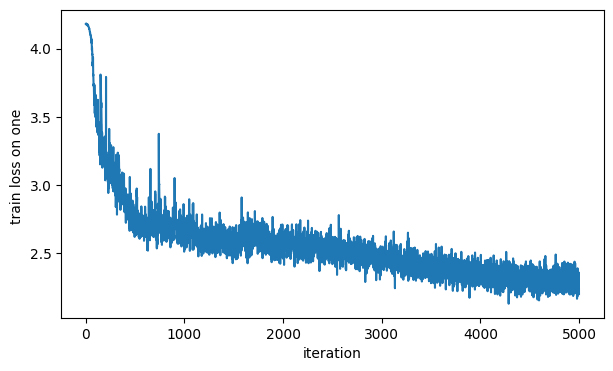

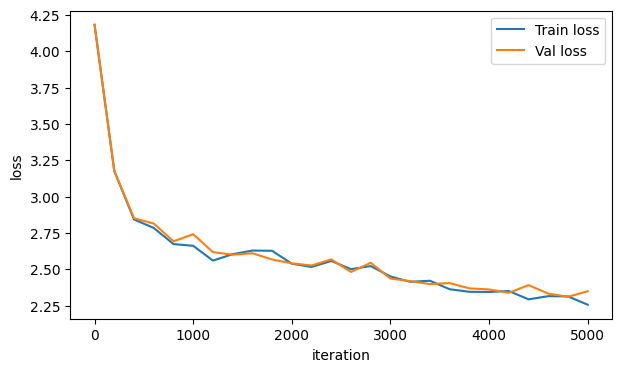

CPU times: user 24min 19s, sys: 16min 11s, total: 40min 30s
Wall time: 17min 14s


In [6]:
%%time

#-------------------------------------------------------------------------------
# List to track loss during training
iter_loss = []
LOSSES = []

# Training ...
for iter in range(num_iterations): 
    optimizer.step()
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    xb, yb = get_batch(train_data, batch_size, block_size)         # Sample a batch of training data
    probs, loss = model(xb, yb)                                    # Forward pass to calculate loss
    optimizer.zero_grad(set_to_none=True)                          # Reset gradients to avoid accumulation
    loss.backward()                                                # Backpropagation to compute gradients
    optimizer.step()                                               # Update model parameters

    iter_loss.append(loss.item())                                  # Append the current loss to track progress
    
    # print progress after a certain number of iterations
    if iter % 200 == 0:
        train_val_losses = estimate_loss(eval_iters=eval_iters)  # Note: this estimation is taking some time
        print(f'Iteration: {iter:4d},  Learning Rate = {current_lr:.6f},   mean train loss: {train_val_losses[0]:.4f},   mean val loss: {train_val_losses[1]:.4f}')
        LOSSES.append([iter, train_val_losses[0], train_val_losses[1]])

#-------------------------------------------------------------------------------

plt.figure(figsize=(7,4))
plt.plot(iter_loss)
plt.xlabel('iteration')
plt.ylabel('train loss on one ')
plt.show()


LOSSES = np.array(LOSSES)
plt.figure(figsize=(7,4))
plt.plot(LOSSES[:,0], LOSSES[:,1], label='Train loss')
plt.plot(LOSSES[:,0], LOSSES[:,2], label='Val loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

### Generate text from the trained RT model

In [7]:
%%time

print(decode(model.generate(x = torch.tensor([[0]], dtype=torch.long).to(device), block_size=block_size, max_new_tokens=1000)[0].tolist()))


Ane mot;
Ord thrucar moll muchawben oke ke t yoranus e
ce: tee nacouclitece s: athomintinsw
Nin, bs Forot thoulst ZAre thir prges spain'Ar f, mields cheromseum ngerdst canesiats!
Wh y, counce t fotou o me the
Hotay ca nes hathisbe th ous, myomare cho, lothand aschut thind?

RDIthte, thond wow,

Dof f tholltr berea!
I dfu houtsty wey,
Whe Ofronys graituput wenge! mshith deas,
Brd py hrum fofay ithemags d bedin,
Founew yorren is thut alat h yime'limiss t,
m stereralind han I sivent neald-w!
ANULoomore atant tesomow gir buss usshoid f are chand yo!
Pin ch, weriothe
ARTAnf:
Lord amen; nsut faur ar RGreprafengi oom,
OMy YAUCloraund
My yoy ched, nottourland r me ugaver dion.

St ot, KINze!

ARDUCKI
ANDnd bow! lorckn suck al inounde 'den he e an loun mby e
tiglllllikid t array ierathy, t lbinoustincht wal te;
I int txer nam hisot ang bus dink.


IS: that, RGLICENplocest, :
Itar I foro'r I cary: fathe wisthan baw we lfligit nomyo od;

Thoros! thand we, yo forooupBy CCin su nern or y mat ce do